# Decition Tree Regressor
https://www.python-course.eu/Regression_Trees.php

In [1]:
import pandas as pd
import numpy as np

In [3]:
100000000 / 430000

232.5581395348837

In [14]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [15]:
df = pd.read_csv('UCI_BikeSharing_day.csv', usecols=['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'cnt'])

In [13]:
df.sample(frac=1).head()

,season,holiday,weekday,workingday,weathersit,cnt
35,1,0,6,0,2,1005
189,3,0,6,0,1,5336
131,2,0,4,1,1,4864
427,1,0,6,0,2,4066
582,3,0,0,0,1,5464


In [18]:
mean_data = np.mean(df['cnt'])
print(mean_data)

4504.3488372093025


In [96]:
tree

{'season': {1: {'weathersit': {1.0: {'workingday': {0.0: 2328.9736842105262,
      1.0: 3117.1857142857143}},
    2.0: 2385.3898305084745,
    3.0: 1099.3333333333333}},
  2: {'weathersit': {1.0: 5219.677419354839,
    2.0: 4086.7419354838707,
    3.0: 1169.0}},
  3: 4464.36170212766,
  4: 3664.4606741573034}}

In [24]:
"""
Calculate the variance of a dataset
This function takes three arguments.

1. data = The dataset for whose feature the Variance should be calculated
2. split_attribute_name = the name of the feature for which the weighted variance should be calculated
3. targert_name = the name of the target feature. The default for this example is 'cnt'
"""
def var(data, split_attribute_name, target_name='cnt'):
    feature_values = np.unique(data[split_attribute_name])
    feature_variance = 0
    for value in feature_values:
        subset = data.query('{0} == {1}'.format(split_attribute_name, value)).reset_index()
        value_var = (len(subset) / len(data)) * np.var(subset[target_name], ddof=1)
        
        feature_variance += value_var
    return feature_variance


In [75]:
# debug
split_attribute_name = 'season'
target_name='cnt'

feature_values = np.unique(df[split_attribute_name])
print('feature_values:', feature_values)
feature_variance = 0
for value in feature_values:
    subset = df.query('{0} == {1}'.format(split_attribute_name, value)).reset_index()
#     print(subset)
    value_var = (len(subset) / len(df)) * np.var(subset[target_name], ddof=1)
    print(value_var)
    feature_variance += value_var
print(feature_variance)

feature_values: [1 2 3 4]
485267.6699802401
724003.1950169316
548059.1311513785
703402.4381815793
2460732.43433013


In [50]:
def Classification(data, originaldata, features, min_instances, target_attribute_name, parent_node_class= None):
    """
    Classification Algorithm: This function takes the same 5 parameters as the original classsification algorithm in the 
    previous chapter plus one parameter (min_instances) which defines the number of minimal instances per node as early stopping criterion
    """
    # Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
    
        
    #########This criterion is new########################
    #If all target_values have the same value, return the mean value of the target feature for this dataset
    if len(data) <= int(min_instances):
        return np.mean(data[target_attribute_name])
    ######################################################
    
    elif len(data) == 0:
        return np.mean(originaldata[target_attribute_name])

    # If the feature space is empty, return the mean target feature value of the direct parent node --> Note that
    
    # the direct parent node is that node which has called the current run of the algorithm and hence
    # the mean target feature value is stored in the parent_node_class variable.
    elif len(features) == 0:
        return parent_node_class
    
    else: 
        parent_node_class = np.mean(data[target_attribute_name])
        item_values = [var(data, feature) for feature in features]
        best_feature_index = np.argmin(item_values)
        best_feature = features[best_feature_index]
        
        tree = {best_feature: {}}
        
        
        features = [i for i in features if i != best_feature]
        
        for value in np.unique(data[best_feature]):
            value = value
            
            sub_data = data.where(data[best_feature] == value).dropna()
            
            subtree = Classification(sub_data, originaldata, features, min_instances, 'cnt', parent_node_class=parent_node_class)
            
            tree[best_feature][value] = subtree

        return tree

In [81]:
# debug
best_feature = 'season'
for value in np.unique(df[best_feature]):
    print(value)
    sub_data = df.where(df[best_feature] == value).dropna()
    break
sub_data.head()

1


,season,holiday,weekday,workingday,weathersit,cnt
0,1.0,0.0,6.0,0.0,2.0,985.0
1,1.0,0.0,0.0,0.0,2.0,801.0
2,1.0,0.0,1.0,1.0,1.0,1349.0
3,1.0,0.0,2.0,1.0,1.0,1562.0
4,1.0,0.0,3.0,1.0,1.0,1600.0


In [55]:
def predict(query, tree, default = mean_data):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result, dict):
                return predict(query, result)
            else:
                return result

In [56]:
def train_test_split(dataset):
    training_data = dataset.iloc[:int(0.7*len(dataset))].reset_index(drop=True)#We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[int(0.7*len(dataset)):].reset_index(drop=True)
    return training_data,testing_data
training_data = train_test_split(df)[0]
testing_data = train_test_split(df)[1]

In [57]:
def test(data,tree):
    #Create new query instances by simply removing the target feature column from the original dataset and 
    #convert it to a dictionary
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    
    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = []
    #Calculate the RMSE
    for i in range(len(data)):
        predicted.append(predict(queries[i],tree,mean_data)) 
    RMSE = np.sqrt(np.sum(((data.iloc[:,-1]-predicted)**2)/len(data)))
    return RMSE

In [88]:
# debug
queries = df.iloc[:,:-1].to_dict(orient = "records")
queries[0]

{'holiday': 0, 'season': 1, 'weathersit': 2, 'weekday': 6, 'workingday': 0}

In [89]:
tree

{'season': {1: {'weathersit': {1.0: {'workingday': {0.0: 2328.9736842105262,
      1.0: 3117.1857142857143}},
    2.0: 2385.3898305084745,
    3.0: 1099.3333333333333}},
  2: {'weathersit': {1.0: 5219.677419354839,
    2.0: 4086.7419354838707,
    3.0: 1169.0}},
  3: 4464.36170212766,
  4: 3664.4606741573034}}

In [58]:
tree = Classification(training_data,training_data,training_data.columns[:-1],5,'cnt')
pprint(tree)
print('#'*50)
print('Root mean square error (RMSE): ',test(testing_data,tree))

{'season': {1: {'weathersit': {1.0: {'workingday': {0.0: {'holiday': {0.0: {'weekday': {0.0: 2347.235294117647,
                                                                                        6.0: 2347.235294117647}},
                                                                      1.0: 2173.75}},
                                                    1.0: {'holiday': {0.0: {'weekday': {1.0: 3117.1857142857143,
                                                                                        2.0: 3117.1857142857143,
                                                                                        3.0: 3117.1857142857143,
                                                                                        4.0: 3117.1857142857143,
                                                                                        5.0: 3117.1857142857143}}}}}},
                               2.0: {'holiday': {0.0: {'weekday': {0.0: {'workingday': {0.0: 2485.1666666666665}},
  

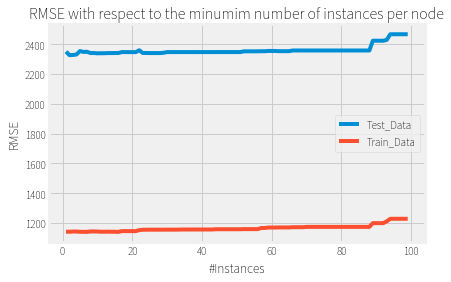

In [59]:
"""
Plot the RMSE with respect to the minimum number of instances
""" 
fig = plt.figure()
ax0 = fig.add_subplot(111) 
RMSE_test = []
RMSE_train = []
for i in range(1,100):
    tree = Classification(training_data,training_data,training_data.columns[:-1],i,'cnt')
    RMSE_test.append(test(testing_data,tree)) 
    RMSE_train.append(test(training_data,tree))
   
ax0.plot(range(1,100),RMSE_test,label='Test_Data')
ax0.plot(range(1,100),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()